In [1]:
import os
print(os.listdir("../input"))

['.DS_Store', 'test.csv', 'train.csv', 'create-extracted-json-fields-dataset', 'sample_submission.csv']


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import gc
import time
from pandas.core.common import SettingWithCopyWarning
import warnings
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from IPython.display import display

# I don't like SettingWithCopyWarnings ...
warnings.simplefilter('error', SettingWithCopyWarning)
gc.enable()
%matplotlib inline

In [66]:
train = pd.read_csv('../input/create-extracted-json-fields-dataset/extracted_fields_train.gz', 
                    dtype={'date': str, 'fullVisitorId': str, 'sessionId':str}, nrows=None)
test = pd.read_csv('../input/create-extracted-json-fields-dataset/extracted_fields_test.gz', 
                   dtype={'date': str, 'fullVisitorId': str, 'sessionId':str}, nrows=None)
train.shape, test.shape

((903653, 30), (804684, 30))

In [67]:
temp = list(train[train.loc[:,'totals.transactionRevenue']>0].loc[:,'totals.transactionRevenue'])
v = np.mean(temp)+np.std(temp)*2

In [68]:
def get_folds(df=None, n_splits=5):
    """Returns dataframe indices corresponding to Visitors Group KFold"""
    # Get sorted unique visitors
    unique_vis = np.array(sorted(df['fullVisitorId'].unique()))

    # Get folds
    folds = GroupKFold(n_splits=n_splits)
    fold_ids = []
    ids = np.arange(df.shape[0])
    for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
        fold_ids.append(
            [
                ids[df['fullVisitorId'].isin(unique_vis[trn_vis])],
                ids[df['fullVisitorId'].isin(unique_vis[val_vis])]
            ]
        )

    return fold_ids

train['totals.transactionRevenue'] = train['totals.transactionRevenue'].fillna(0)
train = train[train.loc[:,'totals.transactionRevenue']<v]
y_reg = train['totals.transactionRevenue']
del train['totals.transactionRevenue']

if 'totals.transactionRevenue' in test.columns:
    del test['totals.transactionRevenue']
    
train['target'] = y_reg
for df in [train, test]:
    df['vis_date'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['sess_date_dow'] = df['vis_date'].dt.dayofweek
    df['sess_date_hours'] = df['vis_date'].dt.hour
    df['sess_date_dom'] = df['vis_date'].dt.day
    df.sort_values(['fullVisitorId', 'vis_date'], ascending=True, inplace=True)
    df['next_session_1'] = (
        df['vis_date'] - df[['fullVisitorId', 'vis_date']].groupby('fullVisitorId')['vis_date'].shift(1)
    ).astype(np.int64) // 1e9 // 60 // 60
    df['next_session_2'] = (
        df['vis_date'] - df[['fullVisitorId', 'vis_date']].groupby('fullVisitorId')['vis_date'].shift(-1)
    ).astype(np.int64) // 1e9 // 60 // 60
    
#     df['max_visits'] = df['fullVisitorId'].map(
#         df[['fullVisitorId', 'visitNumber']].groupby('fullVisitorId')['visitNumber'].max()
#     )
    
    df['nb_pageviews'] = df['date'].map(
        df[['date', 'totals.pageviews']].groupby('date')['totals.pageviews'].sum()
    )
    
    df['ratio_pageviews'] = df['totals.pageviews'] / df['nb_pageviews']
    
#     df['nb_sessions'] = df['date'].map(
#         df[['date']].groupby('date').size()
#     )
    
#     df['nb_sessions_28_ma'] = df['date'].map(
#         df[['date']].groupby('date').size().rolling(28, min_periods=7).mean()
#     )

#     df['nb_sessions_28_ma'] = df['nb_sessions'] / df['nb_sessions_28_ma']

#     df['nb_sessions_per_day'] = df['date'].map(
#         df[['date']].groupby('date').size()
#     )
    
#     df['nb_visitors_per_day'] = df['date'].map(
#         df[['date','fullVisitorId']].groupby('date')['fullVisitorId'].nunique()
#     )

y_reg = train['target']
del train['target']

In [69]:
excluded_features = [
    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 
    'visitId', 'visitStartTime', 'vis_date', 'nb_sessions', 'max_visits'
]

categorical_features = [
    _f for _f in train.columns
    if (_f not in excluded_features) & (train[_f].dtype == 'object')
]

for f in categorical_features:
    train[f], indexer = pd.factorize(train[f])
    test[f] = indexer.get_indexer(test[f])

In [70]:
folds = get_folds(df=train, n_splits=5)

train_features = [_f for _f in train.columns if _f not in excluded_features]
print(train_features)

importances = pd.DataFrame()
oof_reg_preds = np.zeros(train.shape[0])
sub_reg_preds = np.zeros(test.shape[0])
for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train[train_features].iloc[trn_], y_reg.iloc[trn_]
    val_x, val_y = train[train_features].iloc[val_], y_reg.iloc[val_]
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        verbose=100,
        eval_metric='rmse'
    )
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_reg_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_reg_preds[oof_reg_preds < 0] = 0
    _preds = reg.predict(test[train_features], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_reg_preds += np.expm1(_preds) / len(folds)
    
mean_squared_error(np.log1p(y_reg), oof_reg_preds) ** .5

['channelGrouping', 'visitNumber', 'device.browser', 'device.deviceCategory', 'device.isMobile', 'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'trafficSource.adContent', 'trafficSource.campaign', 'trafficSource.isTrueDirect', 'trafficSource.keyword', 'trafficSource.medium', 'trafficSource.referralPath', 'trafficSource.source', 'sess_date_dow', 'sess_date_hours', 'sess_date_dom', 'next_session_1', 'next_session_2', 'nb_pageviews', 'ratio_pageviews']
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.63262
[200]	valid_0's rmse: 1.61523
[300]	valid_0's rmse: 1.6087
[400]	valid_0's rmse: 1.60642
[500]	valid_0's rmse: 1.60512
Early stopping, best iteration is:
[465]	valid_0's rmse: 1.60472
Training until validation scores don't improve for 50 rou

1.5827729925504432

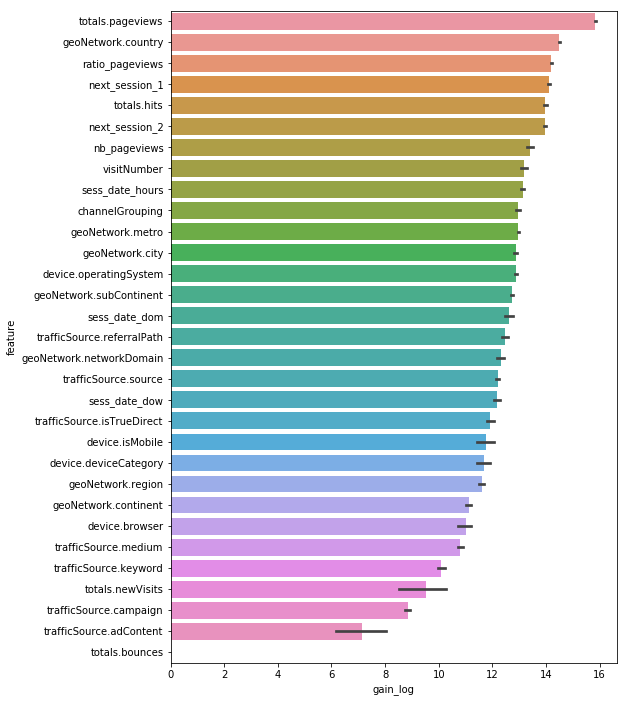

In [73]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

importances['gain_log'] = np.log1p(importances['gain'])
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 12))
sns.barplot(x='gain_log', y='feature', data=importances.sort_values('mean_gain', ascending=False))

In [72]:
train['predictions'] = np.expm1(oof_reg_preds)
test['predictions'] = sub_reg_preds

# Aggregate data at User level
trn_data = train[train_features + ['fullVisitorId']].groupby('fullVisitorId').mean()

In [74]:
%%time
# Create a list of predictions for each Visitor
trn_pred_list = train[['fullVisitorId', 'predictions']].groupby('fullVisitorId')\
    .apply(lambda df: list(df.predictions))\
    .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})

CPU times: user 39.8 s, sys: 653 ms, total: 40.5 s
Wall time: 40.9 s


In [75]:
# Create a DataFrame with VisitorId as index
# trn_pred_list contains dict 
# so creating a dataframe from it will expand dict values into columns
trn_all_predictions = pd.DataFrame(list(trn_pred_list.values), index=trn_data.index)
trn_feats = trn_all_predictions.columns
trn_all_predictions['t_mean'] = np.log1p(trn_all_predictions[trn_feats].mean(axis=1))
trn_all_predictions['t_median'] = np.log1p(trn_all_predictions[trn_feats].median(axis=1))
trn_all_predictions['t_sum_log'] = np.log1p(trn_all_predictions[trn_feats]).sum(axis=1)
trn_all_predictions['t_sum_act'] = np.log1p(trn_all_predictions[trn_feats].fillna(0).sum(axis=1))
trn_all_predictions['t_nb_sess'] = trn_all_predictions[trn_feats].isnull().sum(axis=1)
full_data = pd.concat([trn_data, trn_all_predictions], axis=1)
del trn_data, trn_all_predictions
gc.collect()
full_data.shape

/Users/daiyamita/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log1p
  


(714153, 303)

In [76]:
%%time
sub_pred_list = test[['fullVisitorId', 'predictions']].groupby('fullVisitorId')\
    .apply(lambda df: list(df.predictions))\
    .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})

CPU times: user 38.1 s, sys: 1.09 s, total: 39.2 s
Wall time: 42.3 s


In [77]:
sub_data = test[train_features + ['fullVisitorId']].groupby('fullVisitorId').mean()
sub_all_predictions = pd.DataFrame(list(sub_pred_list.values), index=sub_data.index)
for f in trn_feats:
    if f not in sub_all_predictions.columns:
        sub_all_predictions[f] = np.nan
sub_all_predictions['t_mean'] = np.log1p(sub_all_predictions[trn_feats].mean(axis=1))
sub_all_predictions['t_median'] = np.log1p(sub_all_predictions[trn_feats].median(axis=1))
sub_all_predictions['t_sum_log'] = np.log1p(sub_all_predictions[trn_feats]).sum(axis=1)
sub_all_predictions['t_sum_act'] = np.log1p(sub_all_predictions[trn_feats].fillna(0).sum(axis=1))
sub_all_predictions['t_nb_sess'] = sub_all_predictions[trn_feats].isnull().sum(axis=1)
sub_full_data = pd.concat([sub_data, sub_all_predictions], axis=1)
del sub_data, sub_all_predictions
gc.collect()
sub_full_data.shape

train['target'] = y_reg
trn_user_target = train[['fullVisitorId', 'target']].groupby('fullVisitorId').sum()

/Users/daiyamita/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log1p
  


In [78]:
folds = get_folds(df=full_data[['totals.pageviews']].reset_index(), n_splits=5)

oof_preds = np.zeros(full_data.shape[0])
sub_preds = np.zeros(sub_full_data.shape[0])
vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = full_data.iloc[trn_], trn_user_target['target'].iloc[trn_]
    val_x, val_y = full_data.iloc[val_], trn_user_target['target'].iloc[val_]
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(trn_x, np.log1p(trn_y)), (val_x, np.log1p(val_y))],
        eval_names=['TRAIN', 'VALID'],
        early_stopping_rounds=50,
        eval_metric='rmse',
        verbose=100
    )
    
    imp_df = pd.DataFrame()
    imp_df['feature'] = trn_x.columns
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    vis_importances = pd.concat([vis_importances, imp_df], axis=0, sort=False)
    
    oof_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_preds[oof_preds < 0] = 0
    
    # Make sure features are in the same order
    _preds = reg.predict(sub_full_data[full_data.columns], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_preds += _preds / len(folds)
    
mean_squared_error(np.log1p(trn_user_target['target']), oof_preds) ** .5

Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.5182	VALID's rmse: 1.59117
[200]	TRAIN's rmse: 1.47869	VALID's rmse: 1.58952
Early stopping, best iteration is:
[178]	TRAIN's rmse: 1.48511	VALID's rmse: 1.58915
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.53026	VALID's rmse: 1.54676
[200]	TRAIN's rmse: 1.49071	VALID's rmse: 1.54397
Early stopping, best iteration is:
[195]	TRAIN's rmse: 1.49236	VALID's rmse: 1.54377
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.52241	VALID's rmse: 1.57461
Early stopping, best iteration is:
[130]	TRAIN's rmse: 1.50707	VALID's rmse: 1.57341
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.52271	VALID's rmse: 1.57313
[200]	TRAIN's rmse: 1.48346	VALID's rmse: 1.56879
Early stopping, best iteration is:
[230]	TRAIN's rmse: 1.475	VALID's rmse: 1.56822
Training until validation scores don't improve for 50 rounds.
[10

1.570604040899264

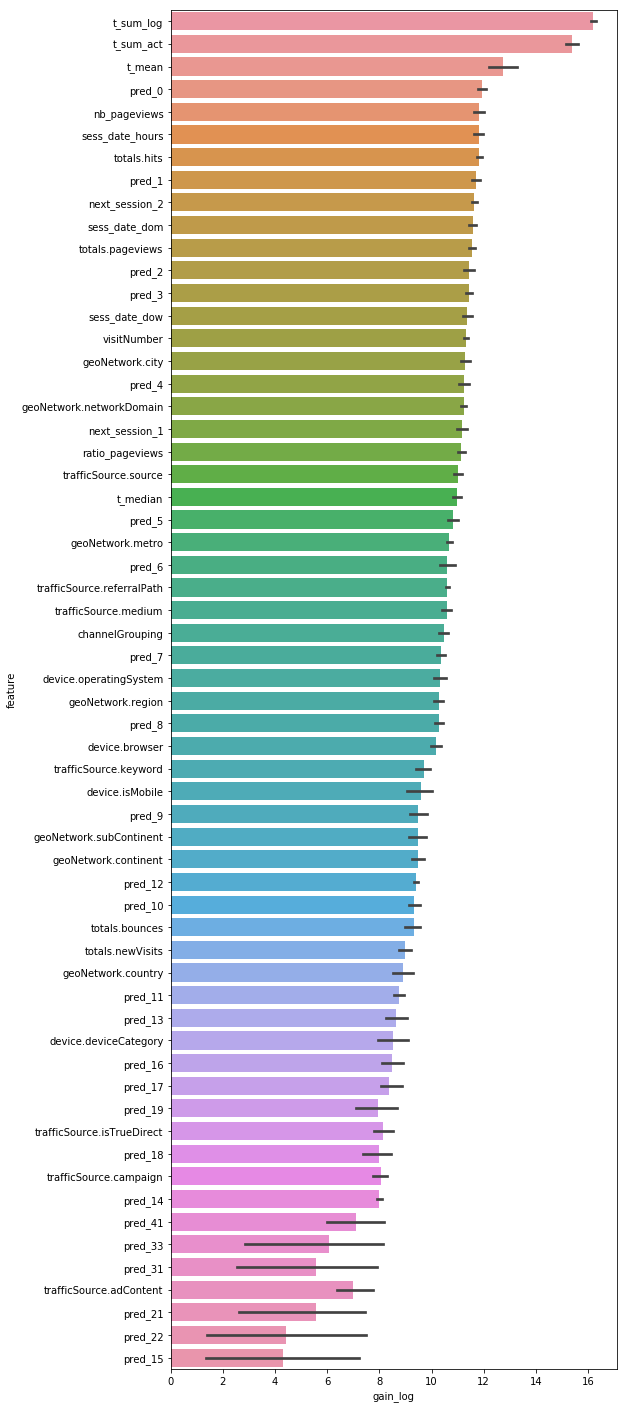

In [79]:
vis_importances['gain_log'] = np.log1p(vis_importances['gain'])
mean_gain = vis_importances[['gain', 'feature']].groupby('feature').mean()
vis_importances['mean_gain'] = vis_importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 25))
sns.barplot(x='gain_log', y='feature', data=vis_importances.sort_values('mean_gain', ascending=False).iloc[:300])

In [80]:
sub_full_data['PredictedLogRevenue'] = sub_preds
sub_full_data[['PredictedLogRevenue']].to_csv('new_test_3.csv', index=True)